# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

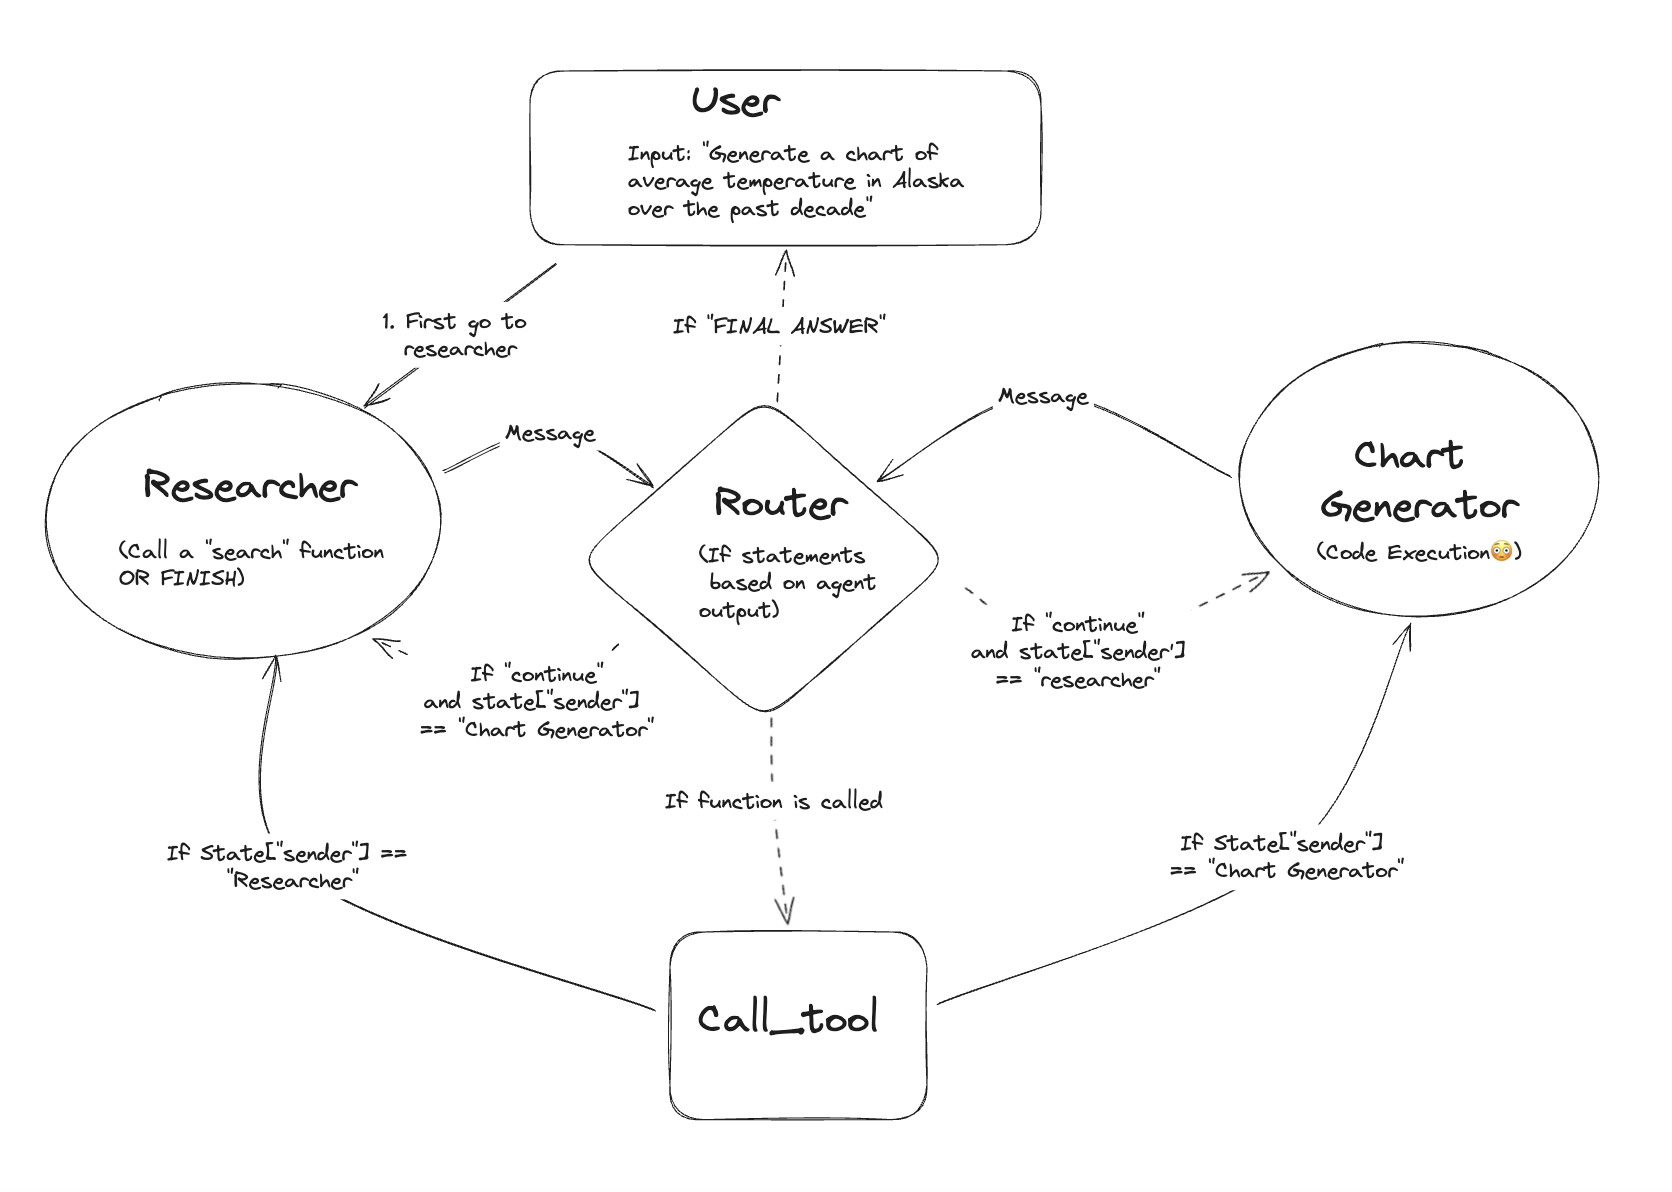

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [4]:
from langgraph.graph import StateGraph, MessagesState, START, END

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(MessagesState):
    sender: str

### Define Routing Logic

We can define some of the routing logic that is needed to decide what to do based on results of the agents.

In [5]:
# Either agent can decide to end
from typing import Literal
from langchain_core.messages import AIMessage


def get_next_node(last_message: AIMessage, goto: str) -> str:
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"

    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END

    return goto

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [6]:
from langchain_core.tools import BaseTool


def make_system_prompt(tools: list[BaseTool], suffix: str) -> str:
    tool_names=", ".join([tool.name for tool in tools])
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f" You have access to the following tools: {tool_names}.\n{suffix}"
    )

Now we can define agent node functions where we'll invoke the tool-calling LLM with the corresponding prompt and determine where to go next based on the response.

In [7]:
from langgraph.types import Control
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")


def call_researcher(state: AgentState) -> Control[Literal["call_tool", "chart_generator", "__end__"]]:
    tools = [tavily_tool]
    system_prompt = make_system_prompt(tools, "You should provide accurate data for the chart_generator to use.")
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.bind_tools(tools).invoke(messages)
    state_update = {
        "messages": [response],
        "sender": "researcher"
    }
    next_node = get_next_node(response, "chart_generator")
    return Control(goto=next_node, state=state_update)


def call_chart_generator(state: AgentState) -> Control[Literal["call_tool", "researcher", "__end__"]]:
    tools = [python_repl_tool]
    system_prompt = make_system_prompt(tools, "Any charts you display will be visible to the user.")
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.bind_tools(tools).invoke(messages)
    state_update = {
        "messages": [response],
        "sender": "chart_generator"
    }
    next_node = get_next_node(response, "researcher")
    return Control(goto=next_node, state=state_update)

### Define Tool Node

We now define a node to run the tools

In [8]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl_tool]
tool_node = ToolNode(tools)

def call_tool(state: AgentState) -> Control[Literal["chart_generator", "researcher"]]:
    response = tool_node.invoke(state)
    return Control(goto=state["sender"], state=response)

### Define the Graph

We can now put it all together and define the graph!

In [9]:
builder = StateGraph(AgentState)

builder.add_node("researcher", call_researcher)
builder.add_node("chart_generator", call_chart_generator)
builder.add_node("call_tool", call_tool)

builder.add_edge(START, "researcher")
graph = builder.compile()

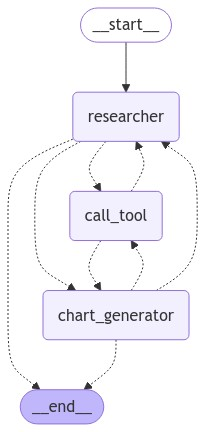

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aq7sXcgyxplcr4Il3uyf1n36', 'function': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 219, 'total_tokens': 242, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-99876a41-83f5-4e5f-9596-418fec08bba4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'call_aq7sXcgyxplcr4Il3uyf1n36', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 23, 'total_tokens': 242, 'input_token_detail

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LfoRuJZRgdCa7N7DFhSDngIH', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for the UK\'s GDP over the past 5 years\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_values = [2858.73, 2697.81, 3141.51, 3088.84, 3340.03]\\n\\n# Create a line chart\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.show()"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 174, 'prompt_tokens': 8128, 'total_tokens': 8302, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'mod

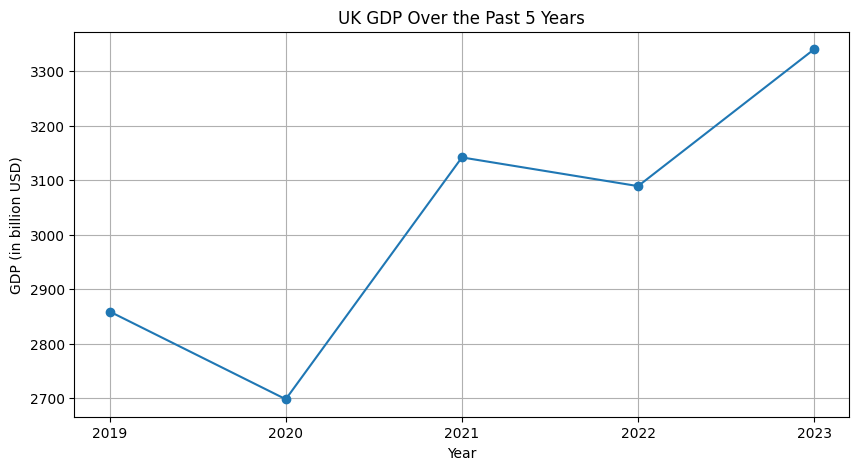

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Data for the UK's GDP over the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [2858.73, 2697.81, 3141.51, 3088.84, 3340.03]\n\n# Create a line chart\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.grid(True)\nplt.xticks(years)\nplt.show()\n\\`\\`\\`\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl_tool', id='049efee8-48b5-4344-a843-dc3c1333332c', tool_call_id='call_LfoRuJZRgdCa7N7DFhSDngIH')]}}
----
{'chart_generator': {'messages': [AIMessage(content="Here is the line chart depicting the UK's GDP over the past five years:\n\n![UK GDP Over the Past 5 Years](attachment://output_4_1.png)\n\nFINAL ANSWER: The chart above shows the UK's GDP from 2019 to 2023.", additional_kwargs=

In [11]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, fetch the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")